# Tutorial 06 - Alignment
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/schedldave/cv2021/blob/main/04_Edges.ipynb)
## Dr. David C. Schedl

Note: this tutorial is geared towards students **experienced in programming** and aims to introduce you to **Computer Vision** techniques.


Useful links:
* OpenCV Tutorials: https://docs.opencv.org/master/d9/df8/tutorial_root.html
* Image Processing in Pyhton: https://github.com/xn2333/OpenCV/blob/master/Seminar_Image_Processing_in_Python.ipynb



# Table of Contents  

- Initialization
- Harris Corner Detector
- Histograms
- SIFT Descriptor
- Feature Matching
- Warping
- Everything Above


<a id="Initialization"></a>

# Initialization

As always let's import useful libraries, first. 
We will work with images today. So let's download some with `curl`.
Let's define utility functions to display images, in Jupyter Notebooks. OpenCV's `imshow` does not work and matplotlib's `imshow` needs special treatment due to color channel handling (RGB vs. BGR)

In [2]:
if 'google.colab' in str(get_ipython()):
  # install a newer opencv version on Colab. The default does not support SIFT!
  !pip install opencv-contrib-python==4.5.*

# import the libraries we use
import os
import cv2 # openCV
import numpy as np
import matplotlib.pyplot as plt



 
# loading images
!curl -o "campus.jpg" "https://www.fh-ooe.at/fileadmin/user_upload/hagenberg/fakultaet/aktuelles/bilder-videos/pics/fhooe-hagenberg-panorama-michael-fruehmann.jpg"
!curl -o "woman.jpg" "https://live.staticflickr.com/8859/18045025168_3a1ffa6521_c_d.jpg"
!curl -o "foto1A.jpg" "https://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg"
!curl -o "foto1B.jpg" "https://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg"

# utility function(s)
def imshow(image, *args, **kwargs):
    """A replacement for cv2.imshow() for use in Jupyter notebooks using matplotlib.

        Args:
          image : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. 
    """
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion  
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    # plt.show()

     |████████████████████████████████| 57.4MB 69kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2161k  100 2161k    0     0  1679k      0  0:00:01  0:00:01 --:--:-- 1679k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 56921    0 56921    0     0   202k      0 --:--:-- --:--:-- --:--:--  202k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  161k  100  161k    0     0   108k      0  0:00:01  0:00:01 --:--:--  108k
  % Total    % Received % Xferd  Average Speed   Time    Time

# SIFT Descriptor

## OpenCV's SIFT implementation

Make sure that you have a recent OpenCV version installed. SIFT was patented and is only free since 2020.



(442, 1250, 3) uint8
(400, 800, 3) (400, 800, 3) uint8


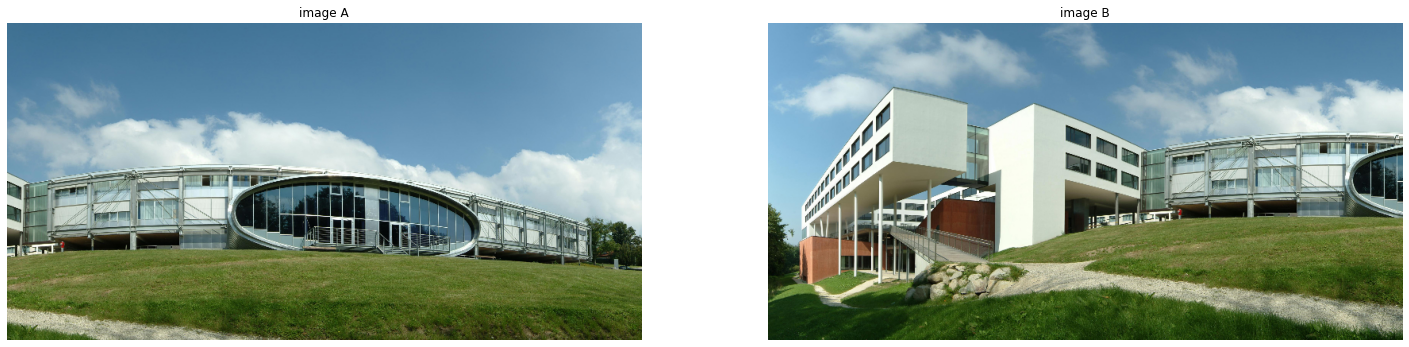

In [3]:
# read images and transform them to grayscale
# Make sure that the train image is the image that will be transformed

huge_img = cv2.imread("campus.jpg")

img = cv2.resize( huge_img, tuple((np.asarray(huge_img.shape[:2])/4).astype(np.int32))[::-1] )
print(img.shape, img.dtype)

imgA = img[:400,    -801:-1,:]
imgB = img[-401:-1, :800,   :]
print(imgA.shape, imgB.shape, imgA.dtype)

# convert to grayscale
imgA_gray = cv2.cvtColor(imgA, cv2.COLOR_RGB2GRAY)
imgB_gray = cv2.cvtColor(imgB, cv2.COLOR_RGB2GRAY)


# display
plt.figure(figsize=(25,10)) # this command makes the figure larger so we see the images better
plt.subplot(121), imshow(imgA, cmap="gray"), plt.title('image A')
plt.subplot(122), imshow(imgB, cmap="gray"), plt.title('image B')
plt.show()

(974, 128)


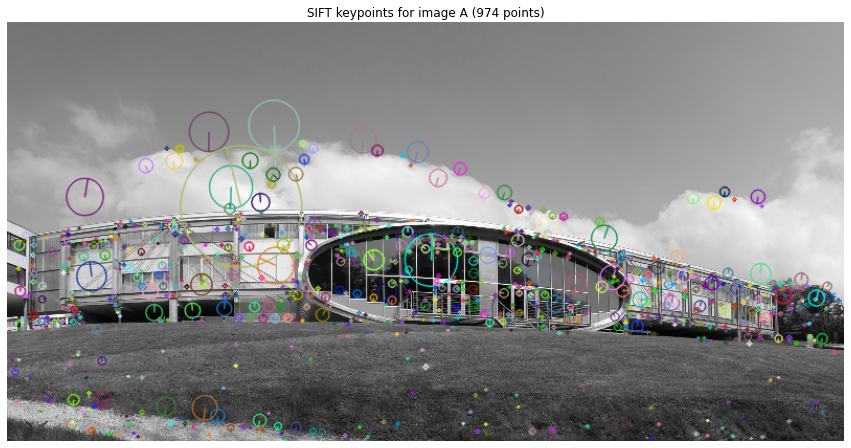

In [4]:
# init sift descriptor
sift = cv2.SIFT_create()

     
# get keypoints and descriptors
(kpsA, featuresA) = sift.detectAndCompute(imgA_gray, None)
print(featuresA.shape)

# display the keypoints
imgA_sift=cv2.drawKeypoints(imgA_gray,kpsA,imgA_gray.copy() ,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display
plt.figure(figsize=(15,10)) # this command makes the figure larger so we see more details
#plt.subplot(121), imshow(imgA, cmap="gray"), plt.title('image 1')
imshow(imgA_sift, cmap="gray"), plt.title('SIFT keypoints for image A ({} points)'.format(featuresA.shape[0]))
plt.show()
    

# Feature Matching

Determine correspondence between interest points in two views by matching the feature descriptors. 

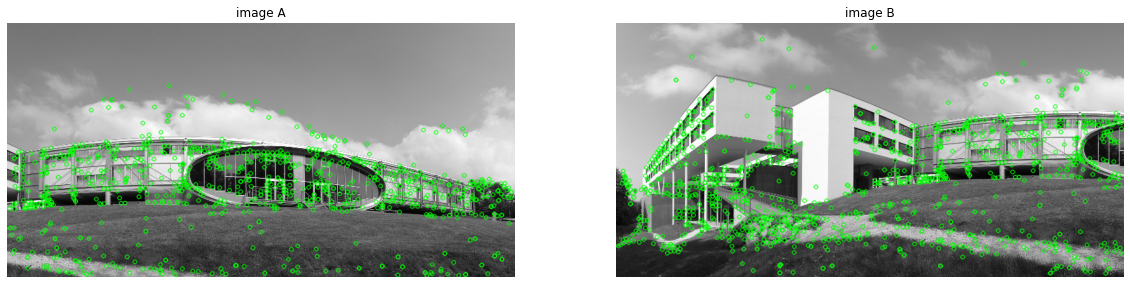

In [5]:
(kpsB, featuresB) = sift.detectAndCompute(imgB_gray, None) # compute features for second image

# display the keypoints and features detected on both images
plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the images better
plt.subplot(121), imshow(cv2.drawKeypoints(imgA_gray,kpsA,None,color=(0,255,0)), cmap="gray"), plt.title('image A')
plt.subplot(122), imshow(cv2.drawKeypoints(imgB_gray,kpsB,None,color=(0,255,0)), cmap="gray"), plt.title('image B')
plt.show()

plt.show()

## Simple Nearest Neighbour Matches

#matches (simple): 543
match[0]:  0.0 0 747 7
match[100]:  0.0 0 865 120


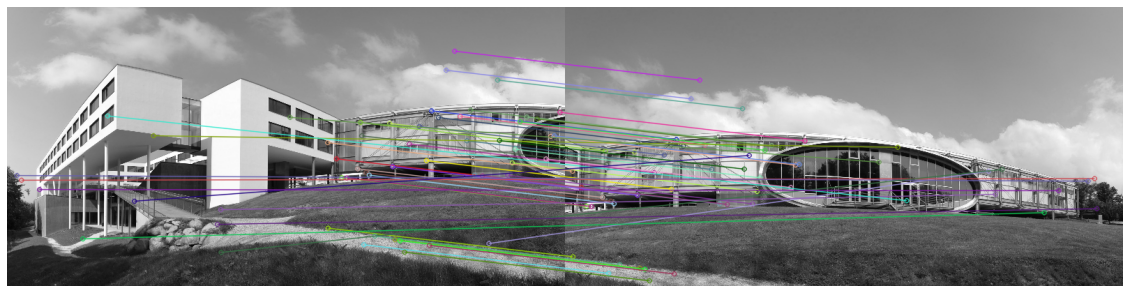

In [6]:
# Simple Nearest Neighbour Matches

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True) # init OpenCV's matcher
    
# Match descriptors.
best_matches = bf.match(featuresB,featuresA)

# Sort the features in order of distance.
# The points with small distance (more similarity) are ordered first in the vector
matches = sorted(best_matches, key = lambda x:x.distance)
print("#matches (simple):", len(matches))
print("match[0]: ", matches[0].distance, matches[0].imgIdx, matches[0].queryIdx, matches[0].trainIdx)
print("match[100]: ", matches[100].distance, matches[100].imgIdx, matches[100].queryIdx, matches[100].trainIdx)

# display (some) matches
img_matches = cv2.drawMatches(imgB_gray,kpsB,imgA_gray,kpsA,matches[:1000:10],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the images better
imshow(img_matches)
plt.show()


Let's look at the offsets of matched features and let's plot them. 

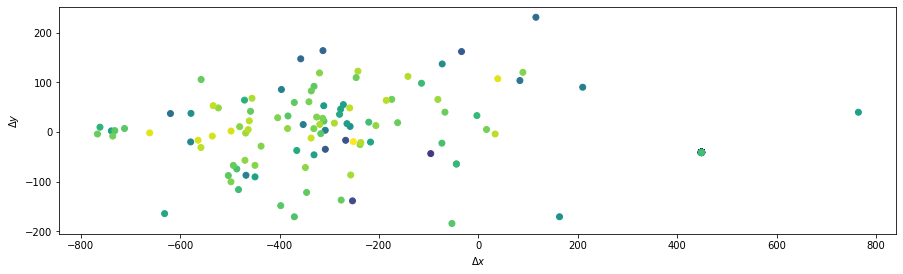

In [7]:
def getMatchedPoints(kpsA, kpsB, featuresA, featuresB, matches):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
       
        return (ptsA, ptsB)
    else:
        return None

(ptsA, ptsB) =    getMatchedPoints(kpsB, kpsA, featuresB, featuresA, matches[:])

diff = ptsA - ptsB # compute offsets between matched points
simDistance = np.float32([m.distance for m in matches])

# display
fig = plt.figure(figsize=(15,10)) # this command makes the figure larger so we see the images better
ax = fig.add_subplot(111)
plt.scatter(diff[:,0],diff[:,1],c=simDistance,cmap='viridis')
ax.set_aspect('equal', adjustable='box'), plt.xlabel('$\Delta x$'), plt.ylabel('$\Delta y$')
plt.show()

 ## Nearest Neigbhor Distance Ratio

#Matches (KNN Distance Ratio): 786
match[0]:  0.0 0 747 7
match[100]:  0.0 0 865 120


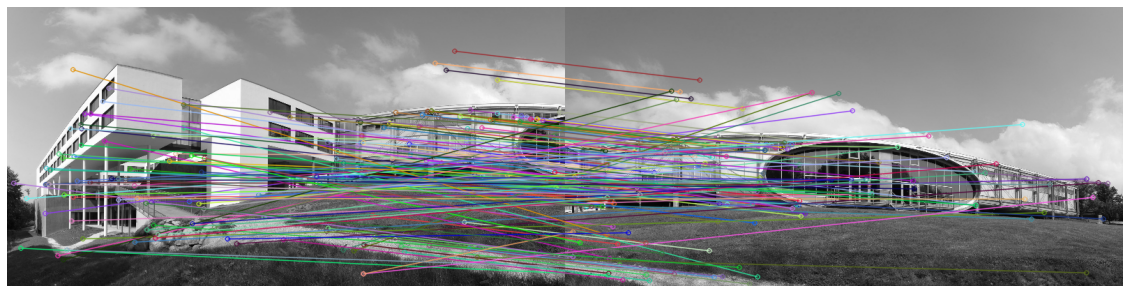

In [33]:
# Nearest Neigbhor Distance Ratio
ratio = 0.95 # optionally use .75
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False) # init OpenCV's matcher

rawMatches = bf.knnMatch(featuresB, featuresA, 2) # retrieves the two nearest neighbours
matches = []

# loop over the raw matches
for m,n in rawMatches:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe's ratio test)
    if m.distance < n.distance * ratio:
        matches.append(m)

# sort based on the distance of the closest neighbour
matches = sorted(matches, key = lambda x:x.distance)

print("#Matches (KNN Distance Ratio):", len(matches))
print("match[0]: ", matches[0].distance, matches[0].imgIdx, matches[0].queryIdx, matches[0].trainIdx)
print("match[100]: ", matches[100].distance, matches[100].imgIdx, matches[100].queryIdx, matches[100].trainIdx)

# display (some) matches
img_matches = cv2.drawMatches(imgB_gray,kpsB,imgA_gray,kpsA,matches[:-1:5],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the images better
imshow(img_matches)
plt.show()


Let's look at the offsets of matched features again. 
This has improved with the NN distance ratio matching!

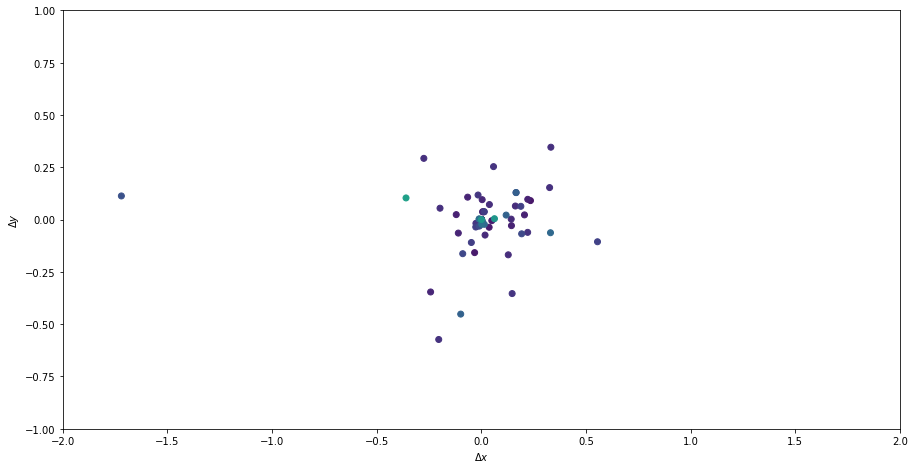

In [34]:
# plot the Δx and Δy of matches points
(ptsA, ptsB) =    getMatchedPoints(kpsB, kpsA, featuresB, featuresA, matches[:])

diff = ptsA - ptsB - [449, -41] # compute offsets between matched points
simDistance = np.float32([m.distance for m in matches])

# display
fig = plt.figure(figsize=(15,10)) # this command makes the figure larger so we see the images better
ax = fig.add_subplot(111)
plt.scatter(diff[:,0],diff[:,1],c=simDistance,cmap='viridis')
#plt.xlim((0,500)), plt.ylim((-100,0))
plt.xlim((-2,2)), plt.ylim((-1,1))

ax.set_aspect('equal', adjustable='box'), plt.xlabel('$\Delta x$'), plt.ylabel('$\Delta y$')
plt.show()

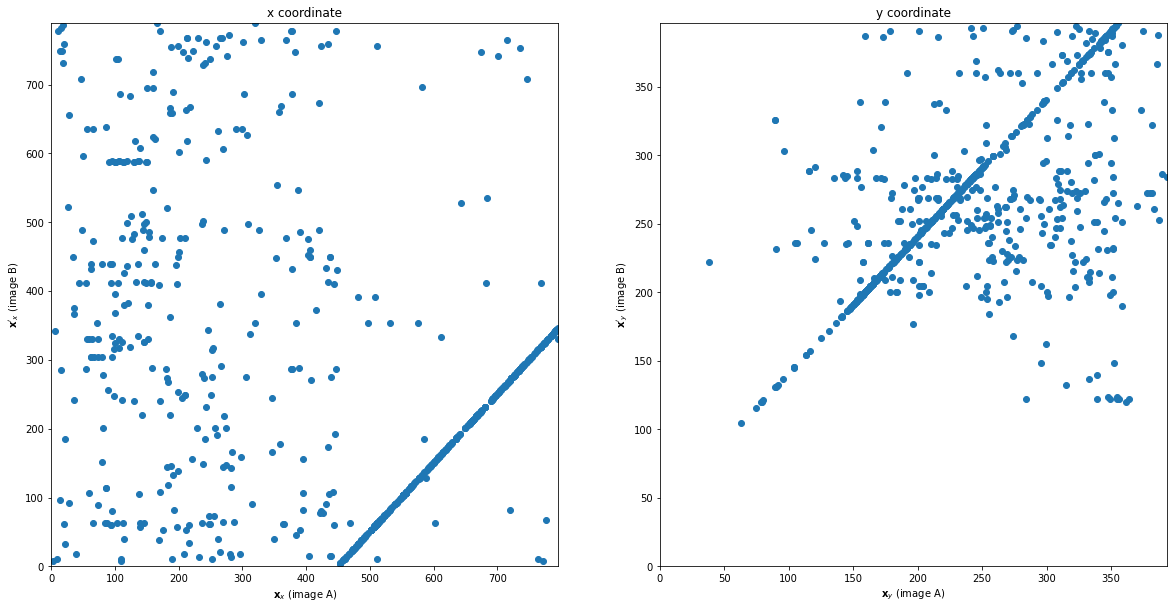

In [35]:
(ptsA, ptsB) =    getMatchedPoints(kpsB, kpsA, featuresB, featuresA, matches[:])

diff = ptsA - ptsB # compute offsets between matched points
simDistance = np.float32([m.distance for m in matches])

# display
fig = plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the images better
plt.subplot(121), plt.scatter(ptsA[:,0], ptsB[:,0]), plt.title( 'x coordinate' )
plt.xlabel('${\\bf x}_x$ (image A)'), plt.ylabel("${\\bf x'}_x$ (image B)")
plt.xlim((0,np.max((ptsA[:,0])))), plt.ylim((0,np.max((ptsB[:,0]))))
plt.subplot(122), plt.scatter(ptsA[:,1], ptsB[:,1]), plt.title( 'y coordinate' )
plt.xlabel('${\\bf x}_y$ (image A)'), plt.ylabel("${\\bf x'}_y$ (image B)")
plt.xlim((0,np.max((ptsA[:,1])))), plt.ylim((0,np.max((ptsB[:,1]))))


plt.show()

[186.49024371 -25.35855164]


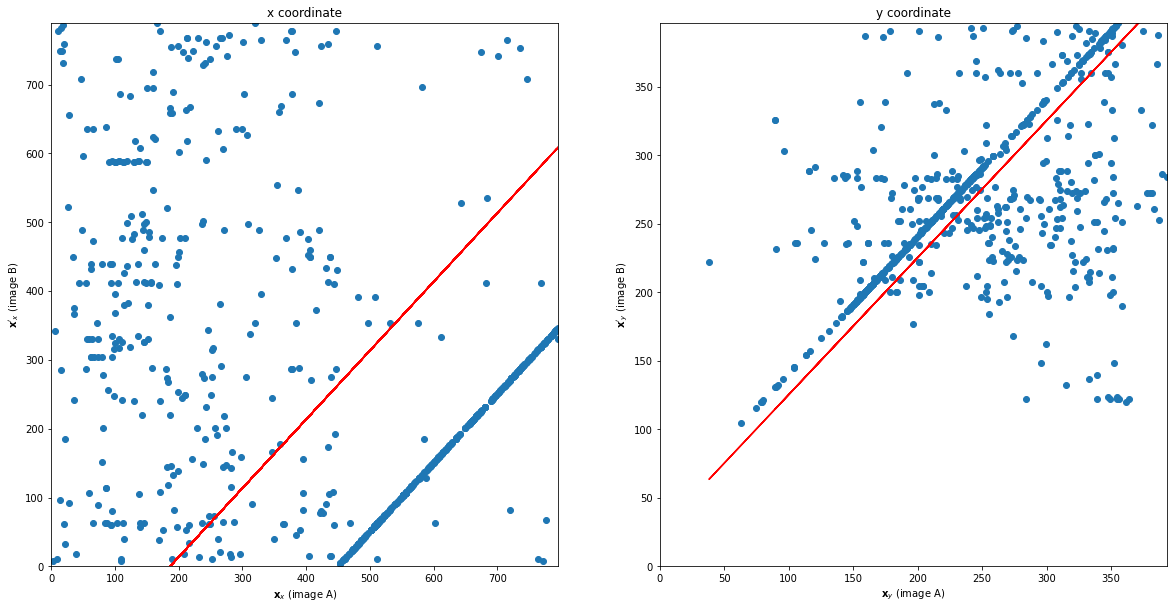

In [36]:
from scipy.optimize import least_squares

# define the translational model
def transl_model(t):
    residual = ptsA - (ptsB + t)
    return np.linalg.norm( residual, axis=1 )


t0 = np.array([0, 0]) # initial guess
res = least_squares(transl_model, t0)
print(res.x)

modelB = ptsA - res.x

# display
fig = plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the images better
plt.subplot(121), plt.scatter(ptsA[:,0], ptsB[:,0]), plt.title( 'x coordinate' )
plt.plot(ptsA[:,0], modelB[:,0], color='red')
plt.xlabel('${\\bf x}_x$ (image A)'), plt.ylabel("${\\bf x'}_x$ (image B)")
plt.xlim((0,np.max((ptsA[:,0])))), plt.ylim((0,np.max((ptsB[:,0]))))
plt.subplot(122), plt.scatter(ptsA[:,1], ptsB[:,1]), plt.title( 'y coordinate' )
plt.plot(ptsA[:,1], modelB[:,1], color='red')
plt.xlabel('${\\bf x}_y$ (image A)'), plt.ylabel("${\\bf x'}_y$ (image B)")
plt.xlim((0,np.max((ptsA[:,1])))), plt.ylim((0,np.max((ptsB[:,1]))))
plt.show()

[448.9909777  -41.01486956]


((0.0, 393.475341796875), (0.0, 396.7467041015625))

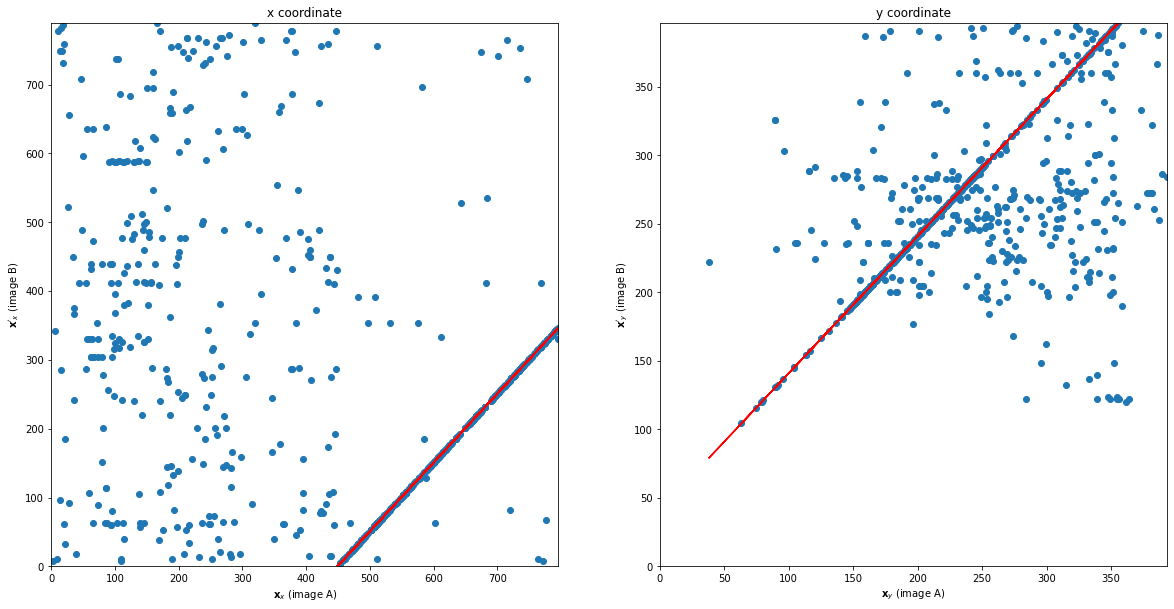

In [37]:
# estimate using RANSAC
(H, status) = cv2.estimateAffine2D(ptsB, ptsA, cv2.RANSAC)
print(H[:,2]) # translation

modelB = ptsA - H[:,2]

# display
fig = plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the images better
plt.subplot(121), plt.scatter(ptsA[:,0], ptsB[:,0]), plt.title( 'x coordinate' )
plt.plot(ptsA[:,0], modelB[:,0], color='red')
plt.xlabel('${\\bf x}_x$ (image A)'), plt.ylabel("${\\bf x'}_x$ (image B)")
plt.xlim((0,np.max((ptsA[:,0])))), plt.ylim((0,np.max((ptsB[:,0]))))
plt.subplot(122), plt.scatter(ptsA[:,1], ptsB[:,1]), plt.title( 'y coordinate' )
plt.plot(ptsA[:,1], modelB[:,1], color='red')
plt.xlabel('${\\bf x}_y$ (image A)'), plt.ylabel("${\\bf x'}_y$ (image B)")
plt.xlim((0,np.max((ptsA[:,1])))), plt.ylim((0,np.max((ptsB[:,1]))))



# Warping

## Simple Translational Model

Let's merge the two images by translating/warping one image (image A). 
So we assume that a point $\bf x$ in one image corresponds to $\bf x' = \bf x + \bf t$ in the second image, where $\bf t$ is the translation.

[[  1.        0.      449.00146]
 [  0.        1.      -41.00114]]


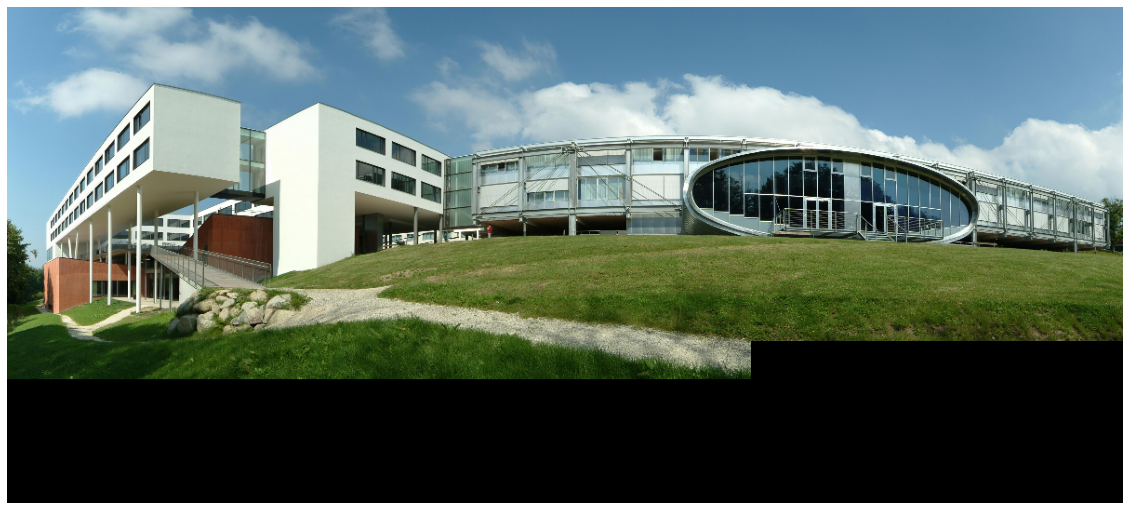

In [13]:
num_best_matches = int(len(matches)) # only use the best matches

# estimate the image translation with the offset of matched points
shiftX, shiftY = np.mean(diff[:num_best_matches,0]), np.mean(diff[:num_best_matches,1])
H = np.float32([
	[1, 0, shiftX],
	[0, 1, shiftY]
])
print(H) # print the translation matrix

# make sure the new image is large enough
width  = imgA.shape[1] + int(imgB.shape[1]/2)
height = imgA.shape[0] + int(imgB.shape[0]/3)

# warp image A to image B
result = cv2.warpAffine(imgA, H, (width, height))
result[0:imgB.shape[0], 0:imgB.shape[1]] = imgB

plt.figure(figsize=(20,10))
imshow(result)
plt.show()

## Perspective Transformation Model

As shown above, the assumption that a simple translation is enough to warp image A correctly onto B is not correct. The edges do not perfectly match because of this. 
Therefore, let's try to estimate a perspective transformation matrix (which has 8 degrees of freedom), which handles a variety of transformations.

[[ 1.00004036e+00 -2.02576220e-05  4.48999701e+02]
 [-3.13945709e-06  1.00007275e+00 -4.10190869e+01]]


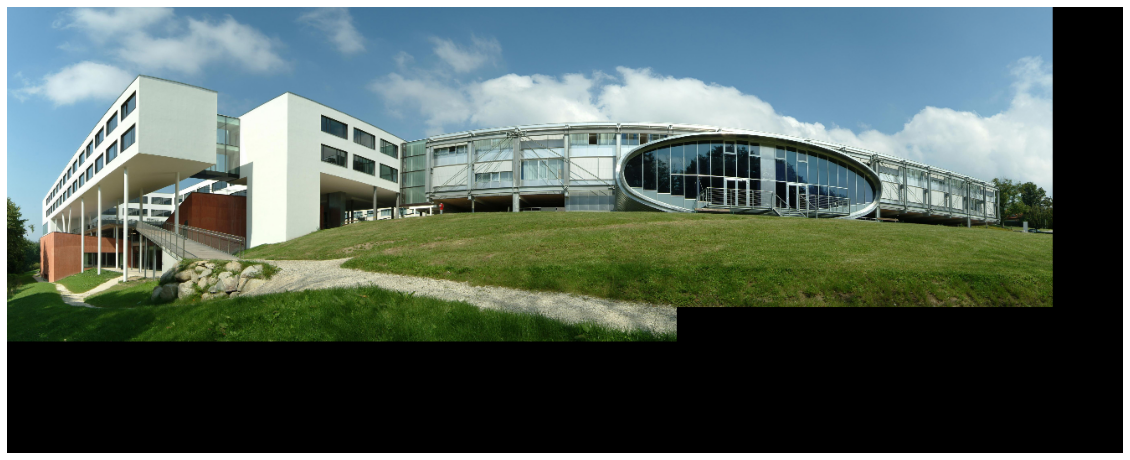

In [14]:
# estimate the homography between the sets of points
(H, status) = cv2.estimateAffine2D(ptsB, ptsA, cv2.RANSAC)
print(H) # the matrix is 3x3 now

# make sure the new image is large enough
width  = imgA.shape[1] + int(imgB.shape[1]*2/3)
height = imgA.shape[0] + int(imgB.shape[0]/3)

# warp image A to image B
result = cv2.warpAffine(imgA, H, (width, height))
result[0:imgB.shape[0], 0:imgB.shape[1]] = imgB

plt.figure(figsize=(20,10))
imshow(result)
plt.show()


# Everything above (in one line): OpenCV's Image Stitcher 

We could have avoided all the steps above by simply using OpenCV's image stitcher. It does something similar like what we did above and also smoothly blends images. But where is the fun in that? 😃

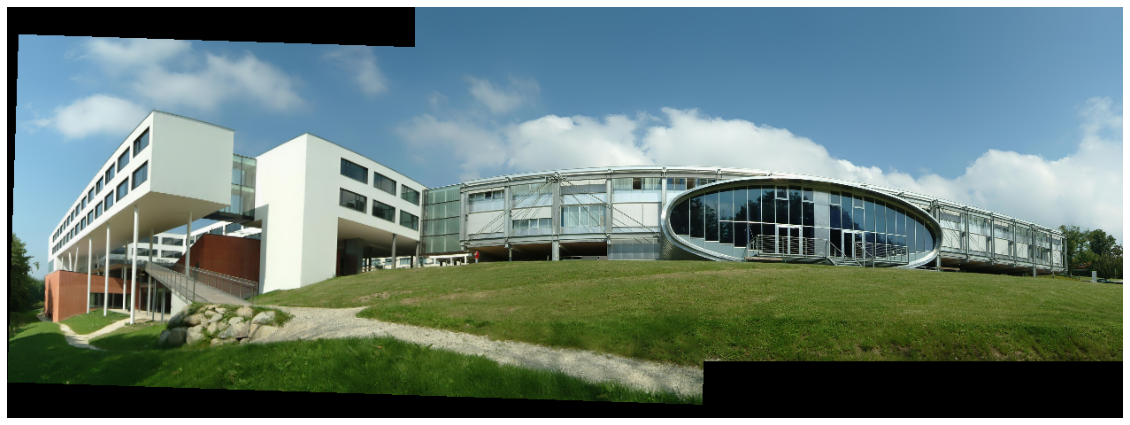

In [15]:
# initialize OpenCV's image stitcher object and then perform the image
# stitching
images = [imgA, imgB]
stitcher = cv2.Stitcher_create( mode=1 ) # mode=0 is panorama and assumes spherical stitichg, mode=1 is scan
(status, stitched) = stitcher.stitch(images)

if status==0: # stitching worked!
  plt.figure(figsize=(20,10))
  imshow(stitched)